Data limited clients

In this file we have Convergence plot for 

- 1. Box plot for Data Limited (CFedDC, FedDC, and FedMEM)
- 2. Line plot for Data Limited (CFedDC, FedDC, and FedMEM)
- 1. Line plot for Data Rich (CFedDC, FedDC, and FedMEM)
- 2. Line plot for (CFedDC, FedDC, and FedMEM)
- 1. Box plot for (CFedDC, FedDC, and FedMEM)
- 2. Line plot for (CFedDC, FedDC, and FedMEM)


In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

Number of rounds to plot: 30


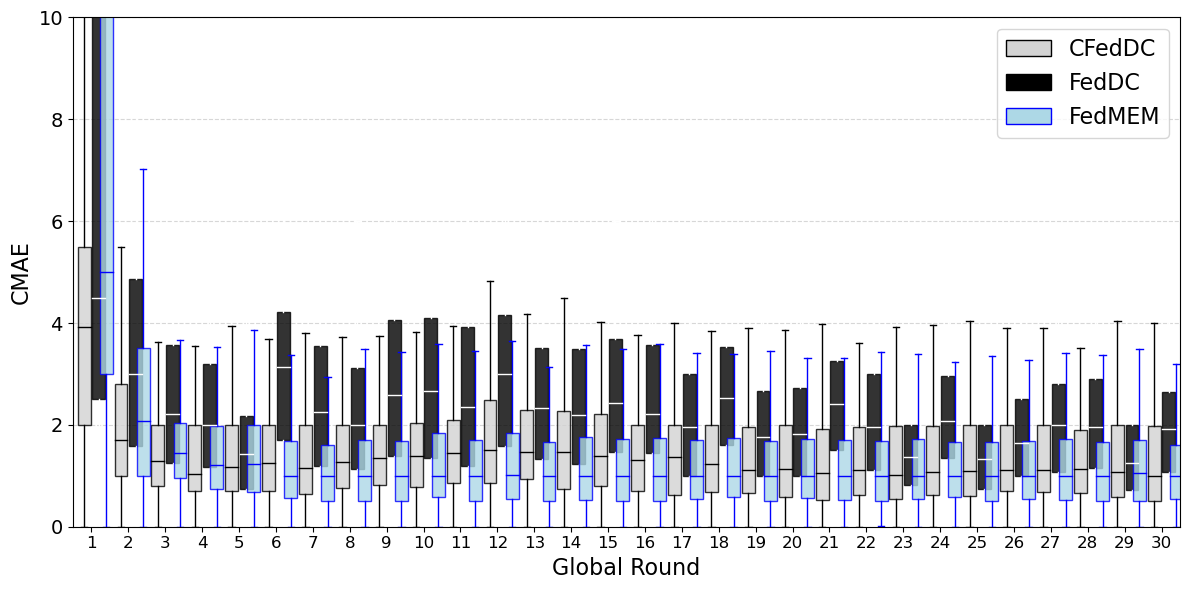

Saved boxplot comparison (grey & black) at:
    /proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level/all_mae/resourceless_boxplot_FedDC_vs_CFedDC_vs_FedMEM_grey_black.png


In [2]:
# ─── CONFIGURATION ────────────────────────────────────────────────────────────
base_dir  = "/proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level"
algos     = ["CFedDC", "FedMEM", "FedDC"]
num_users = 535

# Prepare containers to hold each “resourceless” user’s per-round CMAE lists:
cmae_lists = { algo: [] for algo in algos }

# ─── STEP 1: COLLECT “RESOURCELESS” USERS’ CMAE DATA ───────────────────────────
for user_id in range(num_users):
    filename     = f"user_{user_id}_test_round_results.json"
    cfeddc_path  = os.path.join(base_dir, "CFedDC_KT_RL", "local_test", filename)
    fedmem_path  = os.path.join(base_dir, "FedMEM", "local_test", filename)
    feddc_path   = os.path.join(base_dir, "FedDC",  "local_test", filename)

    # 1a) Must have CFedDC JSON so we can check the resource_category
    if not os.path.exists(cfeddc_path):
        continue

    try:
        with open(cfeddc_path, "r") as f:
            data_cf = json.load(f)
    except Exception as e:
        print(f"[Warning] Could not read {cfeddc_path}: {e}")
        continue

    # 1b) Only keep users whose resource_category == "resourceless"
    rc = data_cf.get("resource_category", "Unknown").replace(" user", "").lower()
    if rc != "resourceless":
        continue

    # 1c) Now ensure FedDC JSON also exists
    if not os.path.exists(feddc_path):
        continue

    try:
        with open(feddc_path, "r") as f:
            data_fd = json.load(f)
    except Exception as e:
        print(f"[Warning] Could not read {feddc_path}: {e}")
        continue

    # 1c) Now ensure FedMEM JSON also exists
    if not os.path.exists(fedmem_path):
        continue

    try:
        with open(fedmem_path, "r") as f:
            data_fm = json.load(f)
    except Exception as e:
        print(f"[Warning] Could not read {fedmem_path}: {e}")
        continue

    # 1d) Extract per-round CMAE (key is "info_cmae")
    cmae_cf = data_cf.get("validation_results", {}).get("info_cmae", [])
    cmae_fm = data_fm.get("validation_results", {}).get("info_cmae", [])
    cmae_fd = data_fd.get("validation_results", {}).get("info_cmae", [])

    # Skip if either list is empty
    if not cmae_cf or not cmae_fd or not cmae_fm: 
        continue

    # 1e) Append each user's CMAE list to the respective algorithm's container
    cmae_lists["CFedDC"].append(cmae_cf)
    cmae_lists["FedDC"].append(cmae_fd)
    cmae_lists["FedMEM"].append(cmae_fm)

# ─── STEP 2: ORGANIZE DATA “BY ROUND” ───────────────────────────────────────────
# Ensure we found at least one resourceless user for each algorithm
if len(cmae_lists["CFedDC"]) == 0 or len(cmae_lists["FedDC"]) == 0 or len(cmae_lists["FedMEM"]) == 0:
    raise RuntimeError("No resourceless users found for CFedDC, FedMEM and/or FedDC.")

# Find the maximum number of rounds across all resourceless users for each algorithm
max_rounds_cf = max(len(lst) for lst in cmae_lists["CFedDC"])
max_rounds_fd = max(len(lst) for lst in cmae_lists["FedDC"])
max_rounds_fm = max(len(lst) for lst in cmae_lists["FedMEM"])

# We only want to plot up to the minimum of these two maxima,
# so that both algorithms have data for each round we show.
common_rounds = min(max_rounds_cf, max_rounds_fd, max_rounds_fm, 30)

# Create lists of length common_rounds; each inner list accumulates all CMAE values at that round
cf_by_round = [[] for _ in range(common_rounds)]
fd_by_round = [[] for _ in range(common_rounds)]
fm_by_round = [[] for _ in range(common_rounds)]

# Populate cf_by_round
for user_list in cmae_lists["CFedDC"]:
    for r in range(len(user_list)):
        if r < common_rounds:
            cf_by_round[r].append(user_list[r])

# Populate fd_by_round
for user_list in cmae_lists["FedDC"]:
    for r in range(len(user_list)):
        if r < common_rounds:
            fd_by_round[r].append(user_list[r])

# Populate fm_by_round
for user_list in cmae_lists["FedMEM"]:
    for r in range(len(user_list)):
        if r < common_rounds:
            fm_by_round[r].append(user_list[r])

# ─── STEP 3: DRAW GROUPED BOXPLOTS IN ONE FIGURE (GREY & BLACK) ───────────────
plt.figure(figsize=(12, 6))

# X positions: 1, 2, …, common_rounds
rounds = np.arange(1, common_rounds + 1)
print(f"Number of rounds to plot: {common_rounds}")
offset = 0.20  # horizontal shift so boxes don't overlap exactly

# Positions for CFedDC and FedDC boxes
pos_cf = rounds - offset
pos_fd = rounds + offset
pos_fm = rounds + 2 * offset  # For FedMEM, if needed

# 3a) CFedDC boxplot (light grey fill, black edges & median)
plt.boxplot(
    cf_by_round,
    positions=pos_cf,
    widths=0.35,
    patch_artist=True,
    showfliers=False,
    boxprops=dict(facecolor="lightgrey", edgecolor="black", alpha=0.8),
    medianprops=dict(color="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(markeredgecolor="black"),
)

# 3b) FedDC boxplot (black fill, white median & white whiskers)
plt.boxplot(
    fd_by_round,
    positions=pos_fd,
    widths=0.35,
    patch_artist=True,
    showfliers=False,
    boxprops=dict(facecolor="black", edgecolor="black", alpha=0.8),
    medianprops=dict(color="white"),
    whiskerprops=dict(color="white"),
    capprops=dict(color="white"),
    flierprops=dict(markeredgecolor="white"),
)

# 3c) FedMEM boxplot (optional, if you want to include it)
plt.boxplot(
    fm_by_round,
    positions=pos_fm,
    widths=0.35,
    patch_artist=True,
    showfliers=False,
    boxprops=dict(facecolor="lightblue", edgecolor="blue", alpha=0.8),
    medianprops=dict(color="blue"),
    whiskerprops=dict(color="blue"),
    capprops=dict(color="blue"),
    flierprops=dict(markeredgecolor="blue"),
)

# 3c) Force x-axis ticks to be exactly at 1, 2, …, common_rounds
plt.xticks(
    rounds,                          # tick locations
    [str(r) for r in rounds],       # tick labels
    fontsize=12
)
plt.xlim(0.5, common_rounds + 0.5)  # ensure the first and last boxes are fully visible

# 3d) Labels, title, and grid
plt.xlabel("Global Round", fontsize=16)
plt.ylabel("CMAE", fontsize=16)
#plt.title("Resourceless Users: CMAE Distribution per Round\n(CFedDC vs. FedDC)", fontsize=16)
plt.yticks(fontsize=14)
plt.ylim(0.0,10.0)                  # keep the same y-limit
plt.grid(axis="y", linestyle="--", alpha=0.5)

# 3e) Custom legend (grey = CFedDC, black = FedDC)
import matplotlib.patches as mpatches
patch_cf = mpatches.Patch(facecolor="lightgrey", edgecolor="black", label="CFedDC")
patch_fd = mpatches.Patch(facecolor="black", edgecolor="black", label="FedDC")
patch_fm = mpatches.Patch(facecolor="lightblue", edgecolor="blue", label="FedMEM")
plt.legend(handles=[patch_cf, patch_fd, patch_fm], fontsize=16, loc="upper right")

plt.tight_layout()

# 3f) Save the figure
save_path = os.path.join(base_dir, "all_mae", "resourceless_boxplot_FedDC_vs_CFedDC_vs_FedMEM_grey_black.png")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path)
plt.show()  # Show the plot in the notebook (optional)
plt.close()

print(f"Saved boxplot comparison (grey & black) at:\n    {save_path}")


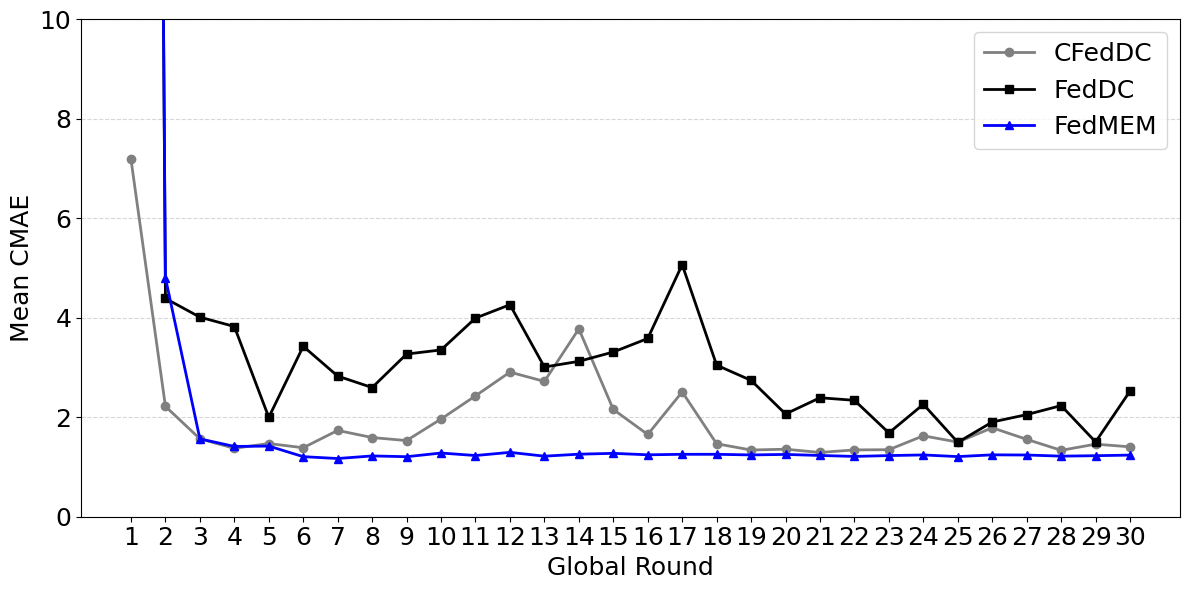

Saved line plot comparison at:
    /proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level/all_cmae/resourceless_lineplot_FedDC_vs_CFedDC_vs_FedMEM.png


In [3]:
# ─── STEP 3: DRAW LINE PLOT FOR EACH ALGORITHM ────────────────────────────────
plt.figure(figsize=(12, 6))

# Compute per-round average CMAE
mean_cf_by_round = [np.mean(r) if r else np.nan for r in cf_by_round]
mean_fd_by_round = [np.mean(r) if r else np.nan for r in fd_by_round]
mean_fm_by_round = [np.mean(r) if r else np.nan for r in fm_by_round]

rounds = np.arange(1, common_rounds + 1)

# Plot lines for each algorithm
plt.plot(rounds, mean_cf_by_round, marker='o', label='CFedDC', color='grey', linewidth=2)
plt.plot(rounds, mean_fd_by_round, marker='s', label='FedDC', color='black', linewidth=2)
plt.plot(rounds, mean_fm_by_round, marker='^', label='FedMEM', color='blue', linewidth=2)

# Labels, title, and grid
plt.xlabel("Global Round", fontsize=18)
plt.ylabel("Mean CMAE", fontsize=18)
# plt.title("Resourceless Users: CMAE per Round (Line Plot)", fontsize=16)
plt.xticks(rounds, fontsize=18)
plt.yticks(fontsize=18)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0.0, 10.0)
plt.legend(fontsize=18, loc="best")

plt.tight_layout()

# Save the figure
save_path = os.path.join(base_dir, "all_cmae", "resourceless_lineplot_FedDC_vs_CFedDC_vs_FedMEM.png")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path)
plt.show()
plt.close()

print(f"Saved line plot comparison at:\n    {save_path}")


Data Rich

In [4]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# ─── CONFIGURATION ────────────────────────────────────────────────────────────
base_dir  = "/proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level"
algos     = ["CFedDC", "FedMEM", "FedDC"]
num_users = 535

# Prepare containers to hold each “resourceless” user’s per-round CMAE lists:
cmae_lists = { algo: [] for algo in algos }

# ─── STEP 1: COLLECT “RESOURCELESS” USERS’ CMAE DATA ───────────────────────────
for user_id in range(num_users):
    filename     = f"user_{user_id}_test_round_results.json"
    cfeddc_path  = os.path.join(base_dir, "CFedDC_KT_RL", "local_test", filename)
    fedmem_path  = os.path.join(base_dir, "FedMEM", "local_test", filename)
    feddc_path   = os.path.join(base_dir, "FedDC",  "local_test", filename)

    # 1a) Must have CFedDC JSON so we can check the resource_category
    if not os.path.exists(cfeddc_path):
        continue

    try:
        with open(cfeddc_path, "r") as f:
            data_cf = json.load(f)
    except Exception as e:
        print(f"[Warning] Could not read {cfeddc_path}: {e}")
        continue

    # 1b) Only keep users whose resource_category == "resourceless"
    rc = data_cf.get("resource_category", "Unknown").replace(" user", "").lower()
    if rc != "resourceful":
        continue

    # 1c) Now ensure FedDC JSON also exists
    if not os.path.exists(feddc_path):
        continue

    try:
        with open(feddc_path, "r") as f:
            data_fd = json.load(f)
    except Exception as e:
        print(f"[Warning] Could not read {feddc_path}: {e}")
        continue

    # 1c) Now ensure FedMEM JSON also exists
    if not os.path.exists(fedmem_path):
        continue

    try:
        with open(fedmem_path, "r") as f:
            data_fm = json.load(f)
    except Exception as e:
        print(f"[Warning] Could not read {fedmem_path}: {e}")
        continue

    # 1d) Extract per-round CMAE (key is "info_cmae")
    cmae_cf = data_cf.get("validation_results", {}).get("info_cmae", [])
    cmae_fm = data_fm.get("validation_results", {}).get("info_cmae", [])
    cmae_fd = data_fd.get("validation_results", {}).get("info_cmae", [])

    # Skip if either list is empty
    if not cmae_cf or not cmae_fd or not cmae_fm: 
        continue

    # 1e) Append each user's CMAE list to the respective algorithm's container
    cmae_lists["CFedDC"].append(cmae_cf)
    cmae_lists["FedDC"].append(cmae_fd)
    cmae_lists["FedMEM"].append(cmae_fm)

# ─── STEP 2: ORGANIZE DATA “BY ROUND” ───────────────────────────────────────────
# Ensure we found at least one resourceless user for each algorithm
if len(cmae_lists["CFedDC"]) == 0 or len(cmae_lists["FedDC"]) == 0 or len(cmae_lists["FedMEM"]) == 0:
    raise RuntimeError("No resourceless users found for CFedDC, FedMEM and/or FedDC.")

# Find the maximum number of rounds across all resourceless users for each algorithm
max_rounds_cf = max(len(lst) for lst in cmae_lists["CFedDC"])
max_rounds_fd = max(len(lst) for lst in cmae_lists["FedDC"])
max_rounds_fm = max(len(lst) for lst in cmae_lists["FedMEM"])

# We only want to plot up to the minimum of these two maxima,
# so that both algorithms have data for each round we show.
common_rounds = min(max_rounds_cf, max_rounds_fd, max_rounds_fm, 30)

# Create lists of length common_rounds; each inner list accumulates all CMAE values at that round
cf_by_round = [[] for _ in range(common_rounds)]
fd_by_round = [[] for _ in range(common_rounds)]
fm_by_round = [[] for _ in range(common_rounds)]

# Populate cf_by_round
for user_list in cmae_lists["CFedDC"]:
    for r in range(len(user_list)):
        if r < common_rounds:
            cf_by_round[r].append(user_list[r])

# Populate fd_by_round
for user_list in cmae_lists["FedDC"]:
    for r in range(len(user_list)):
        if r < common_rounds:
            fd_by_round[r].append(user_list[r])

# Populate fm_by_round
for user_list in cmae_lists["FedMEM"]:
    for r in range(len(user_list)):
        if r < common_rounds:
            fm_by_round[r].append(user_list[r])

# ─── STEP 3: DRAW GROUPED BOXPLOTS IN ONE FIGURE (GREY & BLACK) ───────────────
plt.figure(figsize=(12, 6))

# X positions: 1, 2, …, common_rounds
rounds = np.arange(1, common_rounds + 1)
print(f"Number of rounds to plot: {common_rounds}")
offset = 0.20  # horizontal shift so boxes don't overlap exactly

# Positions for CFedDC and FedDC boxes
pos_cf = rounds - offset
pos_fd = rounds + offset
pos_fm = rounds + 2 * offset  # For FedMEM, if needed

"""# 3a) CFedDC boxplot (light grey fill, black edges & median)
plt.boxplot(
    cf_by_round,
    positions=pos_cf,
    widths=0.35,
    patch_artist=True,
    showfliers=False,
    boxprops=dict(facecolor="lightgrey", edgecolor="black", alpha=0.8),
    medianprops=dict(color="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(markeredgecolor="black"),
)"""
"""
# 3b) FedDC boxplot (black fill, white median & white whiskers)
plt.boxplot(
    fd_by_round,
    positions=pos_fd,
    widths=0.35,
    patch_artist=True,
    showfliers=False,
    boxprops=dict(facecolor="black", edgecolor="black", alpha=0.8),
    medianprops=dict(color="white"),
    whiskerprops=dict(color="white"),
    capprops=dict(color="white"),
    flierprops=dict(markeredgecolor="white"),
)"""

"""# 3c) FedMEM boxplot (optional, if you want to include it)
plt.boxplot(
    fm_by_round,
    positions=pos_fm,
    widths=0.35,
    patch_artist=True,
    showfliers=False,
    boxprops=dict(facecolor="lightblue", edgecolor="blue", alpha=0.8),
    medianprops=dict(color="blue"),
    whiskerprops=dict(color="blue"),
    capprops=dict(color="blue"),
    flierprops=dict(markeredgecolor="blue"),
)
"""
# 3c) Force x-axis ticks to be exactly at 1, 2, …, common_rounds
# plt.xticks(
#     rounds,                          # tick locations
#     [str(r) for r in rounds],       # tick labels
#     fontsize=12
# )
# plt.xlim(0.5, common_rounds + 0.5)  # ensure the first and last boxes are fully visible

# 3d) Labels, title, and grid
# plt.xlabel("Global Round", fontsize=16)
# plt.ylabel("CMAE", fontsize=16)
# plt.title("Resourceless Users: CMAE Distribution per Round\n(CFedDC vs. FedDC)", fontsize=16)
# plt.yticks(fontsize=14)
# plt.ylim(0.0,10.0)                  # keep the same y-limit
# plt.grid(axis="y", linestyle="--", alpha=0.5)

# 3e) Custom legend (grey = CFedDC, black = FedDC)
# import matplotlib.patches as mpatches
# patch_cf = mpatches.Patch(facecolor="lightgrey", edgecolor="black", label="CFedDC")
# patch_fd = mpatches.Patch(facecolor="black", edgecolor="black", label="FedDC")
# patch_fm = mpatches.Patch(facecolor="lightblue", edgecolor="blue", label="FedMEM")
# plt.legend(handles=[patch_cf, patch_fd, patch_fm], fontsize=16, loc="upper right")

# plt.tight_layout()

# 3f) Save the figure
# save_path = os.path.join(base_dir, "all_mae", "resourceful_boxplot_FedDC_vs_CFedDC_vs_FedMEM_grey_black.png")
# os.makedirs(os.path.dirname(save_path), exist_ok=True)
# plt.savefig(save_path)
# plt.show()  # Show the plot in the notebook (optional)
# plt.close()

# print(f"Saved boxplot comparison (grey & black) at:\n    {save_path}")


Number of rounds to plot: 30


'# 3c) FedMEM boxplot (optional, if you want to include it)\nplt.boxplot(\n    fm_by_round,\n    positions=pos_fm,\n    widths=0.35,\n    patch_artist=True,\n    showfliers=False,\n    boxprops=dict(facecolor="lightblue", edgecolor="blue", alpha=0.8),\n    medianprops=dict(color="blue"),\n    whiskerprops=dict(color="blue"),\n    capprops=dict(color="blue"),\n    flierprops=dict(markeredgecolor="blue"),\n)\n'

<Figure size 1200x600 with 0 Axes>

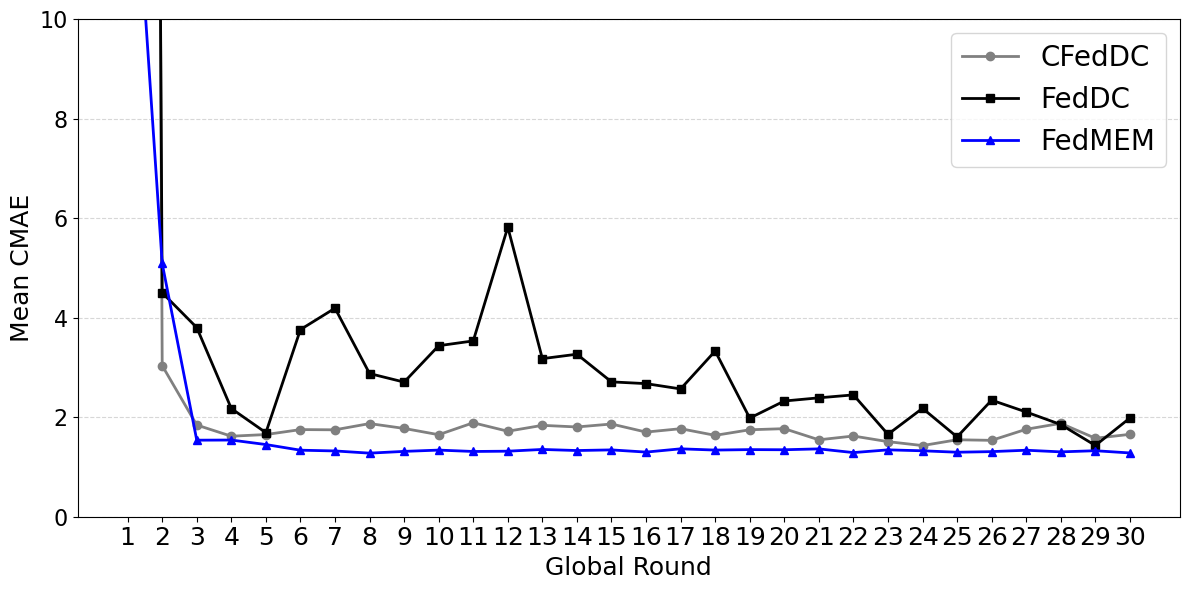

Saved line plot comparison at:
    /proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level/all_cmae/resourceful_lineplot_FedDC_vs_CFedDC_vs_FedMEM.png


In [5]:
# ─── STEP 3: DRAW LINE PLOT FOR EACH ALGORITHM ────────────────────────────────
plt.figure(figsize=(12, 6))

# Compute per-round average CMAE
mean_cf_by_round = [np.mean(r) if r else np.nan for r in cf_by_round]
mean_fd_by_round = [np.mean(r) if r else np.nan for r in fd_by_round]
mean_fm_by_round = [np.mean(r) if r else np.nan for r in fm_by_round]

rounds = np.arange(1, common_rounds + 1)

# Plot lines for each algorithm
plt.plot(rounds, mean_cf_by_round, marker='o', label='CFedDC', color='grey', linewidth=2)
plt.plot(rounds, mean_fd_by_round, marker='s', label='FedDC', color='black', linewidth=2)
plt.plot(rounds, mean_fm_by_round, marker='^', label='FedMEM', color='blue', linewidth=2)

# Labels, title, and grid
plt.xlabel("Global Round", fontsize=18)
plt.ylabel("Mean CMAE", fontsize=18)
# plt.title("Resourceful Users: CMAE per Round (Line Plot)", fontsize=16)
plt.xticks(rounds, fontsize=18)
plt.yticks(fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0.0, 10.0)
plt.legend(fontsize=20, loc="best")

plt.tight_layout()

# Save the figure
save_path = os.path.join(base_dir, "all_cmae", "resourceful_lineplot_FedDC_vs_CFedDC_vs_FedMEM.png")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path)
plt.show()
plt.close()

print(f"Saved line plot comparison at:\n    {save_path}")
